# Import libraries

In [ ]:
! pip install pandas
! pip install numpy
! pip install scikit-learn

In [418]:
import pandas as pd
import numpy as np
import sys
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, LeaveOneOut

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import seaborn as sns

from tqdm import tqdm

from scipy.stats import gaussian_kde
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
from scipy.stats import MonteCarloMethod

# Set constants

In [390]:
PRESENCE_CUTOFF = 0.00001

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [149]:
plt.rcParams['font.family'] = 'Arial'

# Create helper functions and classes

In [143]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

class GMWI(BaseEstimator):

    def __init__(self, use_shannon=False, theta_f=1, theta_d=0):
        self.use_shannon = use_shannon
        self.fitted = False
        self.thresh = 0.00001
        self.health_abundant = None
        self.health_scarce = None
        self.features = None
        self.theta_f = theta_f
        self.theta_d = theta_d

    def fit(self, X, y):
        """
        Identifies health_abundant and health_scarce
        columns/features
        """
        self.features = X.columns
        self.classes_ = np.unique(y)
        if(isinstance(X, pd.DataFrame)):
            X = X.values
        if(isinstance(y, pd.DataFrame)):
            y = y.values
        self.fitted = True
        difference, fold_change = self.get_proportion_comparisons(X, y)
        self.select_features(difference, fold_change)

    def get_proportion_comparisons(self, X, y):
        # get healthy and unhealthy samples
        healthies = X[y.flatten(), :]
        unhealthies = X[~y.flatten(), :]

        # get proportions for each species
        proportion_healthy = self.get_proportions(healthies)
        proportion_unhealthy = self.get_proportions(unhealthies)

        # get differences and fold change
        diff = proportion_healthy - proportion_unhealthy
        fold = proportion_healthy / proportion_unhealthy
        return diff, fold

    def get_proportions(self, samples_of_a_class):
        num_samples = samples_of_a_class.shape[0]
        p = np.sum(samples_of_a_class > self.thresh, axis=0) / num_samples
        return p

    def select_features(self, difference, fold_change):
        # based on proportion differences and fold change, select health abundant
        # and health scarce
        self.health_abundant = self.features[self.cutoff(difference, fold_change)]
        self.health_scarce = self.features[self.cutoff(-1 * difference, 1 / fold_change)]

    def cutoff(self, diff, fold):
        diff_cutoff = diff > self.theta_d
        fold_cutoff = fold > self.theta_f
        both_cutoff = np.bitwise_and(diff_cutoff, fold_cutoff)
        columns = np.where(both_cutoff)
        return columns[0]

    def decision_function(self, X):
        if not self.fitted:
            return None
        if list(X.columns) != list(self.features):
            raise Exception("Model was trained with (different) feature names than input")
        # if(isinstance(X, pd.DataFrame)):
        #    X = X.values
        X_healthy_features = X[self.health_abundant]
        X_unhealthy_features = X[self.health_scarce]
        psi_MH = self.get_psi(X_healthy_features.values) / (
            X_healthy_features.shape[1])
        psi_MN = self.get_psi(X_unhealthy_features.values) / (
            (X_unhealthy_features.shape[1]))
        num = psi_MH + self.thresh
        dem = psi_MN + self.thresh
        return np.log10(num / dem)

    def get_psi(self, X):
        psi = self.richness(X) * 1.0
        if self.use_shannon:
            shan = self.shannon(X)
            psi *= shan
        return psi

    def richness(self, X):
        """
        Returns the number of nonzero values for each sample (row) in X
        """
        rich = np.sum(X > self.thresh, axis=1)
        return rich

    def shannon(self, X):
        logged = np.log(X)
        logged[logged == -np.inf] = 0
        logged[logged == np.inf] = 0
        shan = logged * X * -1
        return np.sum(shan, axis=1)

    def predict(self, X):
        return self.decision_function(X) > 0

# Download and load up data

In [145]:
# download the zipped data if we're in colab
# ! $IN_COLAB && wget https://raw.githubusercontent.com/danielchang2002/GMWI2/main/manuscript/data.zip
    
# unzip the data
# ! unzip data.zip

In [80]:
training_set = pd.read_csv("data/training_set.csv", index_col=[0, 1])

In [81]:
longitudinal_cases = pd.read_csv("data/longitudinal_cases.csv", index_col=[0, 1])

# Exploratory analysis!

## Let's take a look at the pooled dataset (Supplementary Fig. 5)

In [107]:
phenotype = training_set[["Phenotype"]]
phenotype

Phenotype
Study_ID            Sample Accession          
Obregon-Tito (2015) SAMN03283239       Healthy
                    SAMN03283266       Healthy
                    SAMN03283281       Healthy
                    SAMN03283294       Healthy
                    SAMN03283288       Healthy
...                                        ...
Yang (2020)         SRR6456373         Healthy
                    SRR6456374         Healthy
                    SRR6456375         Healthy
                    SRR6456376         Healthy
                    SRR6456377         Healthy

[8069 rows x 1 columns]

In [114]:
dataset_stats = phenotype.reset_index().groupby('Phenotype').agg(lambda x: x.nunique())
dataset_stats.columns = ["# of studies", "# of samples"]
dataset_stats

,# of studies,# of samples
Phenotype,,
Ankylosing spondylitis,1,95
Atherosclerotic cardiovascular disease,1,214
Colorectal cancer,9,789
Crohn's Disease,7,284
Graves’ disease,1,100
Healthy,46,5547
Liver Cirrhosis,1,152
MS,1,24
NAFLD,1,86


## Demographic information (Fig. 1a)

In [177]:
demographics = training_set[["Age", "Sex", "Continent"]]
demographics

Age     Sex      Continent
Study_ID            Sample Accession                             
Obregon-Tito (2015) SAMN03283239      13.0     NaN  South America
                    SAMN03283266      32.0  Female  North America
                    SAMN03283281      52.0  Female  South America
                    SAMN03283294       4.0    Male  South America
                    SAMN03283288      12.0    Male  South America
...                                    ...     ...            ...
Yang (2020)         SRR6456373         NaN     NaN            NaN
                    SRR6456374         NaN     NaN            NaN
                    SRR6456375         NaN     NaN            NaN
                    SRR6456376         NaN     NaN            NaN
                    SRR6456377         NaN     NaN            NaN

[8069 rows x 3 columns]

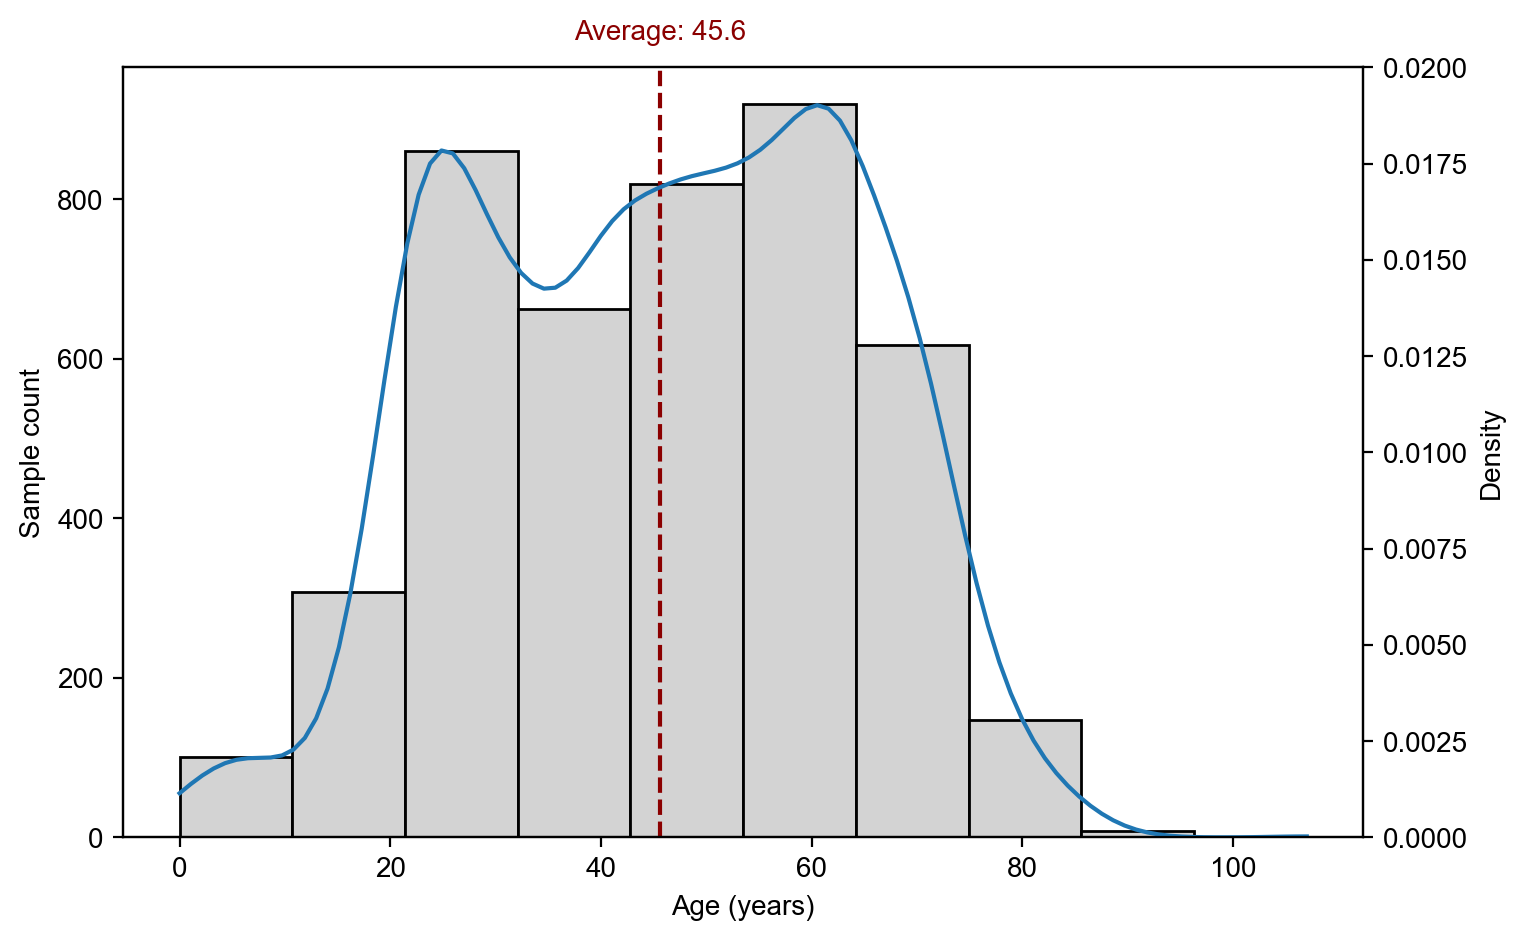

In [201]:
age = demographics[~demographics["Age"].isna()][["Age"]]
mean = float(age.mean())

plt.figure(figsize=(8, 5), dpi=200)
plt.hist(age, edgecolor='k', color='lightgray')

plt.text(mean, 1000, f"Average: {round(mean, 2)}", horizontalalignment='center', color='darkred')
ax = plt.gca()
ax.set_ylabel("Sample count")
ax.set_xlabel("Age (years)")

density = gaussian_kde(age.values.flatten())
lin = np.linspace(age.min(), age.max(), 100)
ax2 = ax.twinx()
ax2.plot(lin, [density(li) for li in lin], zorder=-1)
ax2.set_ylabel("Density")
ax2.set_ylim((0, 0.02))

ax.axline((mean, 0), slope=float('inf'), c='darkred', linestyle="--")
plt.show()

In [242]:
sex = demographics[["Sex"]]
sex_counts = pd.DataFrame(sex.groupby("Sex", dropna=False).size(), columns=["Count"])
sex_counts["Proportion"] = sex_counts["Count"] / sex_counts['Count'].sum()
sex_counts

,Count,Proportion
Sex,,
Female,2583,0.320114
Male,2436,0.301896
NaN,3050,0.377990


In [244]:
continent = demographics[["Continent"]]
cont_counts = pd.DataFrame(continent.groupby("Continent", dropna=False).size(), columns=["Count"])
wedges = ax.pie(cont_counts.values.flatten(), labels=cont_counts.index, wedgeprops=dict(width=1), startangle=-40, autopct="%1.1f%%")
cont_counts["Proportion"] = cont_counts["Count"] / cont_counts['Count'].sum()
cont_counts

,Count,Proportion
Continent,,
Africa,409,0.050688
Asia,3366,0.417152
Europe,2260,0.280084
North America,1525,0.188995
Oceania,79,0.009791
South America,8,0.000991
NaN,422,0.052299


## Principal Component Analysis (Fig. 1b)

In [379]:
X = training_set[[c for c in training_set.columns if c.startswith("UNK") or c.startswith("k__")]]
X

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID            Sample Accession                                            
Obregon-Tito (2015) SAMN03283239        0.000000                     0.000000   
                    SAMN03283266        0.000000                     0.000000   
                    SAMN03283281        0.009764                     0.009764   
                    SAMN03283294        0.000000                     0.000000   
                    SAMN03283288        0.011865                     0.011865   
...                                          ...                          ...   
Yang (2020)         SRR6456373          0.000000                     0.000000   
                    SRR6456374          0.000000                     0.000000   
                    SRR6456375          0.000000                     0.000000   
                    SRR6456376          0.002415                     0.002415   
                    SRR6456377          0.000000                     0.000000   

                                      k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID            Sample Accession                                                   
Obregon-Tito (2015) SAMN03283239                                            0.000000   
                    SAMN03283266                                            0.000000   
                    SAMN03283281                                            0.009764   
                    SAMN03283294                                            0.000000   
                    SAMN03283288                                            0.011865   
...                                                                              ...   
Yang (2020)         SRR6456373                                              0.000000   
                    SRR6456374                                              0.000000   
                    SRR6456375                                              0.000000   
                    SRR6456376                                              0.002415   
                    SRR6456377                                              0.000000   

                                      k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID            Sample Accession                                                                         
Obregon-Tito (2015) SAMN03283239                                               0.000000                      
                    SAMN03283266                                               0.000000                      
                    SAMN03283281                                               0.009764                      
                    SAMN03283294                                               0.000000                      
                    SAMN03283288                                               0.011865                      
...                                                                                 ...                      
Yang (2020)         SRR6456373                                                 0.000000                      
                    SRR6456374                                                 0.000000                      
                    SRR6456375                                                 0.000000                      
                    SRR6456376                                                 0.002415                      
                    SRR6456377                                                 0.000000                      

                                      k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID            Sample Accession                                                                                                
Obregon-Tito (2015) SAMN03283239                                               0.000000                                             
         

In [380]:
y = training_set[["is_healthy"]]
y

is_healthy
Study_ID            Sample Accession            
Obregon-Tito (2015) SAMN03283239            True
                    SAMN03283266            True
                    SAMN03283281            True
                    SAMN03283294            True
                    SAMN03283288            True
...                                          ...
Yang (2020)         SRR6456373              True
                    SRR6456374              True
                    SRR6456375              True
                    SRR6456376              True
                    SRR6456377              True

[8069 rows x 1 columns]

In [385]:
pca = PCA(random_state=42, n_components=2)
pca.fit(X > PRESENCE_CUTOFF)
PC1_variance, PC2_variance = pca.explained_variance_ratio_[:2] * 100
embedding = pca.transform(X > PRESENCE_CUTOFF)
embedding

array([[ 1.69910132,  5.10700429],
       [ 0.29747153, -1.26331052],
       [-0.14752581,  5.75057233],
       ...,
       [-1.1986457 , -0.80476489],
       [-1.10964835,  0.58300576],
       [ 1.11515779,  1.61157009]])

In [394]:
loading = pd.DataFrame(pca.components_.T, index=X.columns, columns=["PC1", "PC2"])
loading.index = [ind.split("|")[-1] for ind in loading.index]
loading

,PC1,PC2
k__Archaea,-0.090106,0.042917
p__Euryarchaeota,-0.090106,0.042917
c__Methanobacteria,-0.090110,0.042939
o__Methanobacteriales,-0.090110,0.042939
f__Methanobacteriaceae,-0.090110,0.042939
...,...,...
s__Pepper_mild_mottle_virus,0.000006,-0.000171
s__Tobacco_mild_green_mosaic_virus,0.000000,-0.000000
s__Deep_sea_thermophilic_phage_D6E,0.000069,0.000084
s__Loktanella_phage_pCB2051_A,0.000000,-0.000000


In [395]:
# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

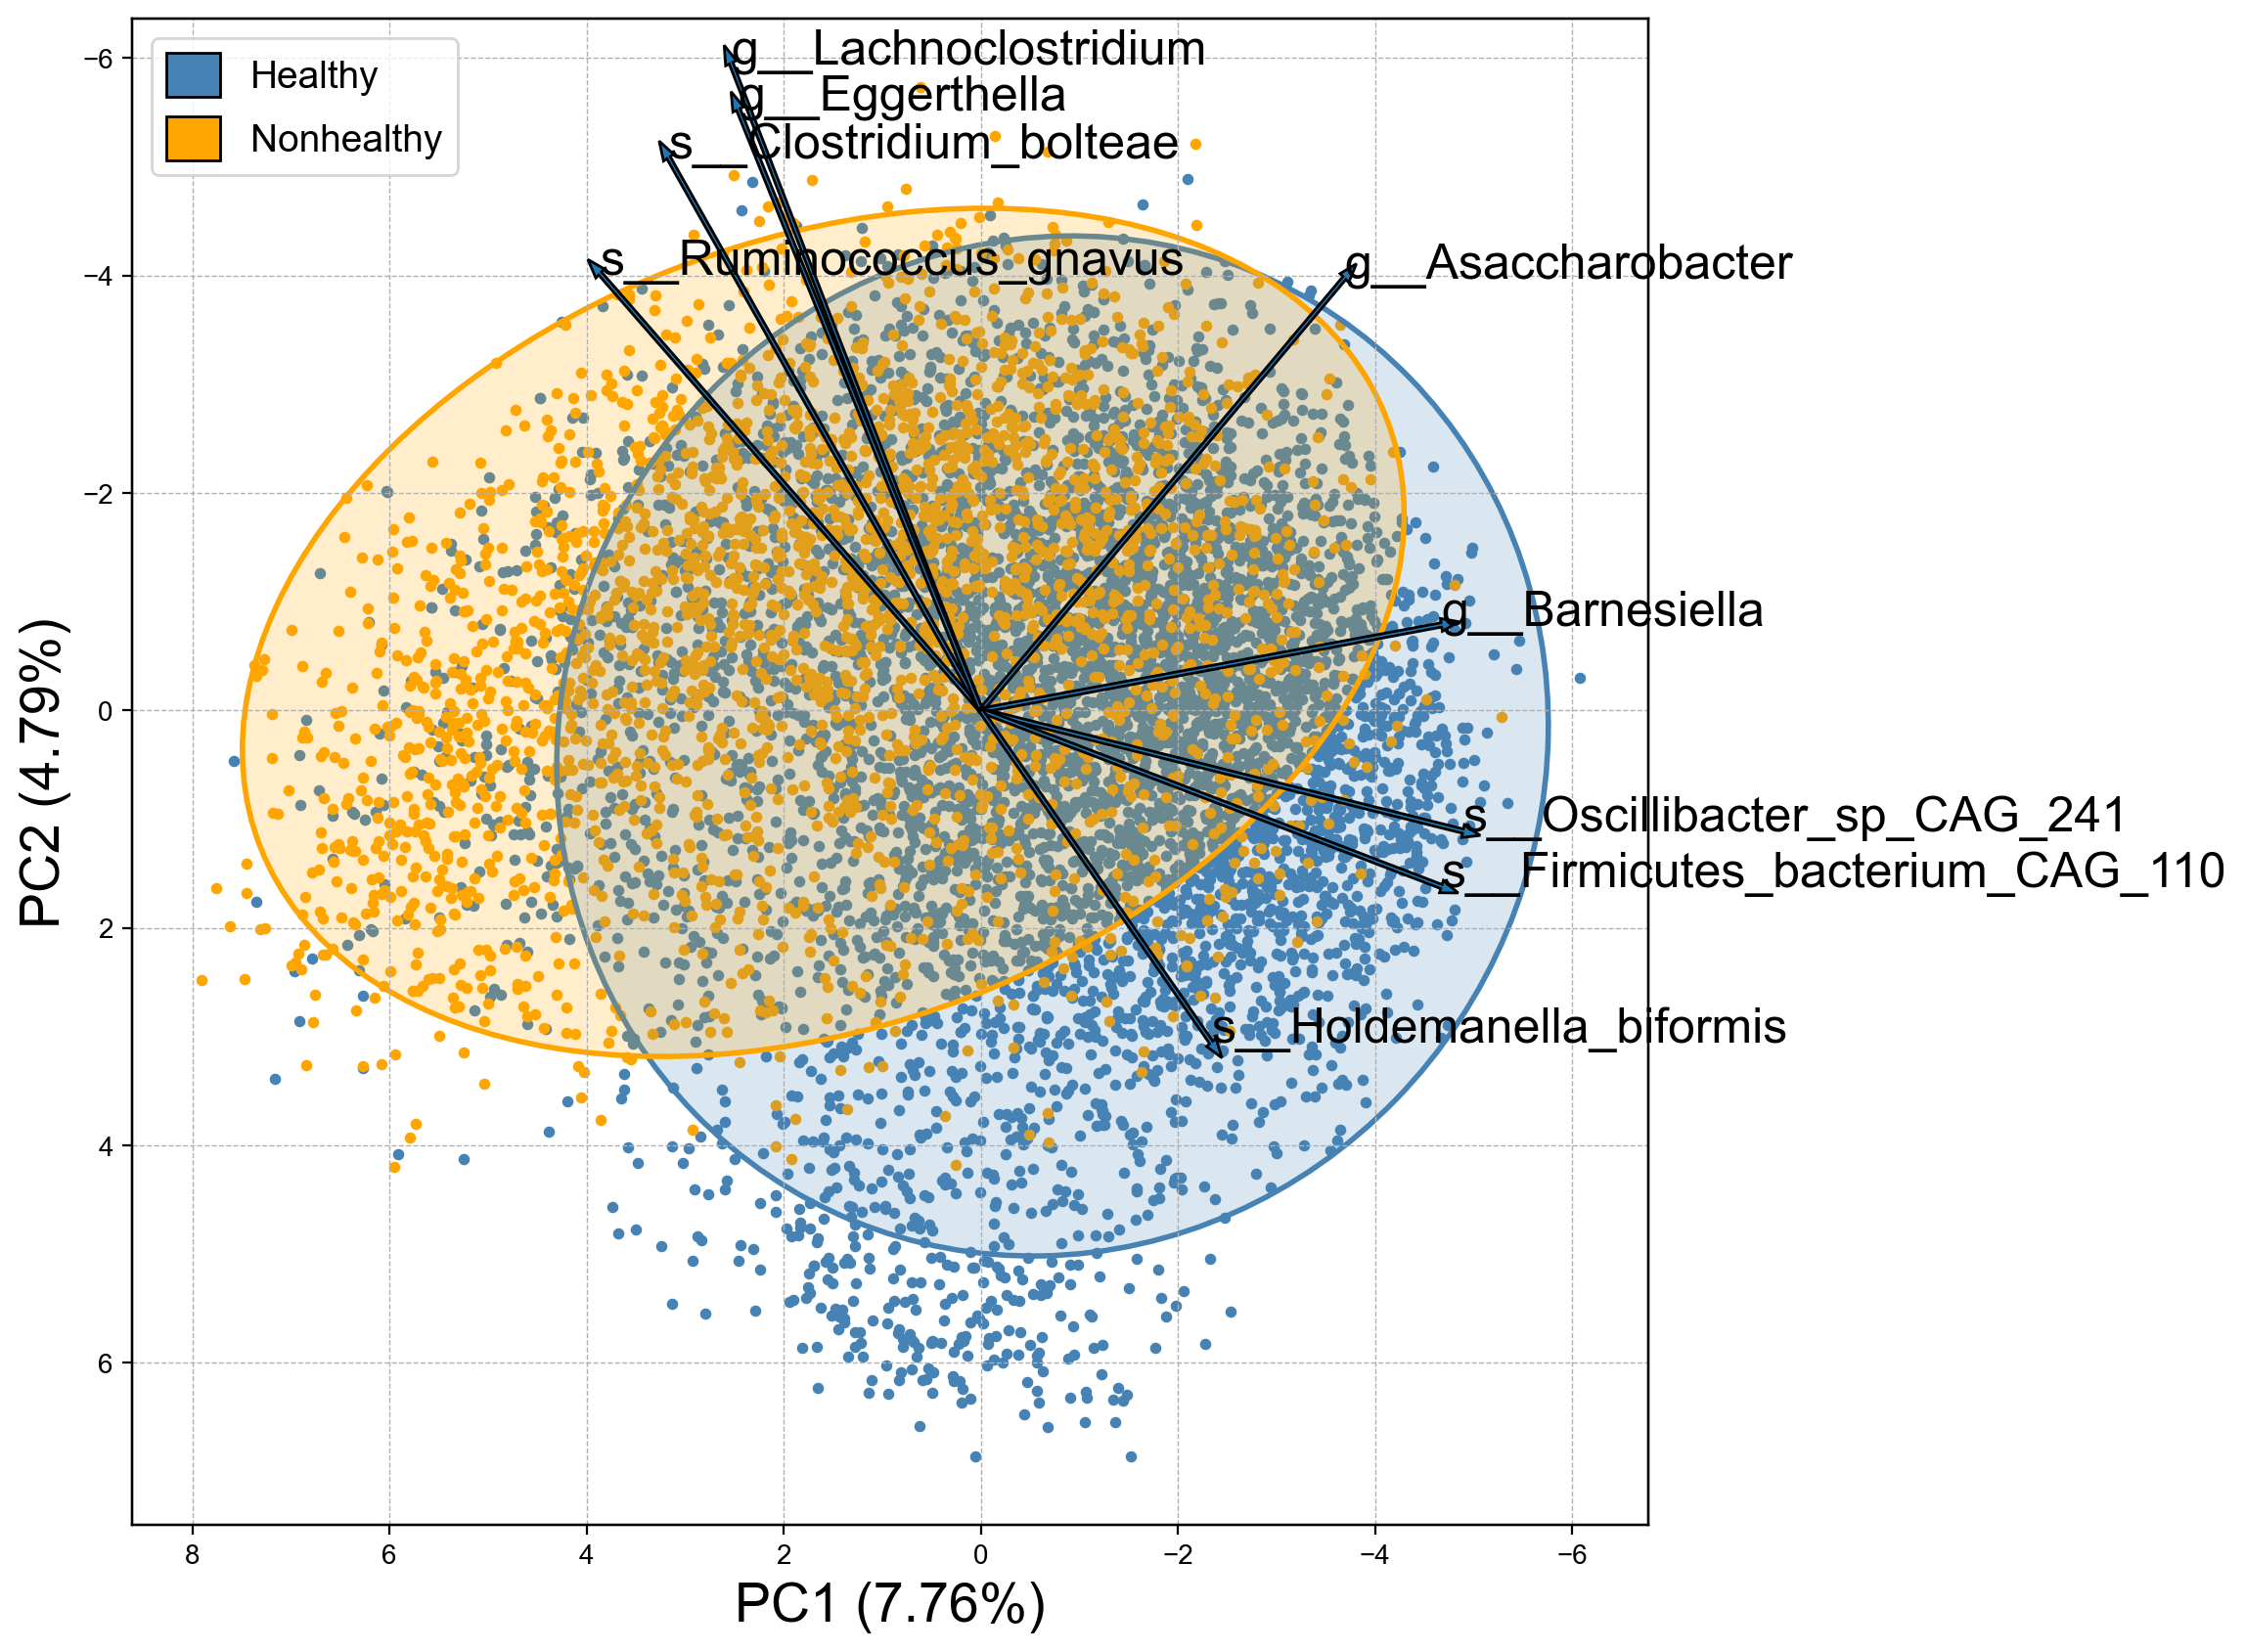

In [408]:
plt.figure(figsize=(10, 10), dpi=200)

ax = plt.gca()

PC1_healthy, PC2_healthy = embedding[y.values.flatten(), 0], embedding[y.values.flatten(), 1]

PC1_nonhealthy, PC2_nonhealthy = embedding[~y.values.flatten(), 0], embedding[~y.values.flatten(), 1]

dot_alpha = 1
dot_size = 10
plt.scatter(PC1_healthy, PC2_healthy, alpha=dot_alpha, s=dot_size, label="Healthy", color=healthy_color)
plt.scatter(PC1_nonhealthy, PC2_nonhealthy, alpha=dot_alpha, s=dot_size, label="Nonhealthy", color=nonhealthy_color)

# 2.25 standard deviations is about 95% confidence in 2D
n_std = 2.25
confidence_ellipse(PC1_healthy, PC2_healthy, plt.gca(), n_std=n_std,
                   alpha=1, edgecolor=healthy_color, lw=2)
confidence_ellipse(PC1_healthy, PC2_healthy, plt.gca(), n_std=n_std,
                   alpha=0.2, facecolor=healthy_color)

confidence_ellipse(PC1_nonhealthy, PC2_nonhealthy, plt.gca(), n_std=n_std,
                   alpha=1, edgecolor=nonhealthy_color, lw=2)
confidence_ellipse(PC1_nonhealthy, PC2_nonhealthy, plt.gca(), n_std=n_std,
                   alpha=0.2, facecolor=nonhealthy_color)

plt.xlabel(f"PC1 ({'{:.2f}'.format(PC1_variance)}%)", fontsize=20)
plt.ylabel(f"PC2 ({'{:.2f}'.format(PC2_variance)}%)", fontsize=20)

handles = [
    Patch(facecolor=healthy_color, edgecolor="k", label="Healthy"),
    Patch(facecolor=nonhealthy_color, edgecolor="k", label="Nonhealthy"),
]

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend(handles=handles, prop={'size': 14}, loc=2, handlelength=1.4, handleheight=1.4)

# plot loading factors

twinx = ax.twinx()

ax_new = twinx.twiny()

loading_taxa = [
    "s__Ruminococcus_gnavus",
    "s__Clostridium_bolteae",
    "g__Lachnoclostridium",
    "g__Eggerthella",
    "g__Asaccharobacter",
    "g__Barnesiella",
    "s__Oscillibacter_sp_CAG_241",
    "s__Firmicutes_bacterium_CAG_110",
    "s__Holdemanella_biformis"
]

for t in loading_taxa:
    pc1, pc2 = loading["PC1"].loc[t], loading["PC2"].loc[t]
    ax_new.arrow(0, 0, pc1, pc2)
    ax_new.text(pc1, pc2, t, fontsize=18)

scale = 0.025

ax_new.set_xlim(x_min * scale, x_max * scale)
ax_new.set_ylim(y_min * scale, y_max * scale)

ax_new.tick_params(
    axis='x',
    which='both',
    top=False,
    labeltop=False,
)

twinx.tick_params(
    axis='y',
    which='both',
    right=False,
    labelright=False,
)

ax.invert_xaxis()
ax.invert_yaxis()

ax_new.invert_xaxis()
ax_new.invert_yaxis()

# Hyperparameter tuning (Supplementary Table 8)

In [249]:
# indentify groups to partition dataset

sample_studies = np.array(X.index.get_level_values(0))
o = OrdinalEncoder()
groups = o.fit_transform(sample_studies.reshape((len(sample_studies), 1))).flatten()
logo = LeaveOneGroupOut()

In [255]:
hyperparam_results = {}

for reg in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]:
    gmwi2 = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=reg, class_weight="balanced")

    # generate logit predictions for each left out study
    GMWI2_scores_ISV = cross_val_predict(gmwi2, X > PRESENCE_CUTOFF, y.values.flatten(), method="decision_function",
        groups=groups, cv=logo, verbose=-1, n_jobs=-1
    )
    
    bal = balanced_accuracy_score(y, GMWI2_scores_ISV > 0)
    hyperparam_results[reg] = bal

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   28.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out

In [262]:
hyperparam_df = pd.DataFrame(hyperparam_results, index=["Balanced accuracy"]).T
hyperparam_df

,Balanced accuracy
0.001,0.500000
0.003,0.708903
0.010,0.742525
0.030,0.757593
0.100,0.741353
0.300,0.727169
1.000,0.713923
3.000,0.695917


In [265]:
REGULARIZATION = hyperparam_df.sort_values("Balanced accuracy").index[-1]
REGULARIZATION

0.03

# Train GMWI2 and GMWI and evaluate on training set

In [266]:
# use same parameters as original paper
gmwi = GMWI(use_shannon=True, theta_f=1.4, theta_d=0.1)

# use only non-viral species
X_GMWI = X.copy()
X_GMWI = X_GMWI[list(filter(lambda x : "s__" in x and "virus" not in x, X_GMWI.columns))]

gmwi.fit(X_GMWI, y)
GMWI_scores = pd.DataFrame(gmwi.decision_function(X_GMWI), index=y.index, columns=["GMWI"])
display(GMWI_scores)
print("GMWI balanced_accuracy on training set:", balanced_accuracy_score(y, GMWI_scores > 0))

GMWI
Study_ID            Sample Accession          
Obregon-Tito (2015) SAMN03283239      3.832094
                    SAMN03283266      1.758548
                    SAMN03283281      3.341858
                    SAMN03283294      1.429055
                    SAMN03283288      1.064592
...                                        ...
Yang (2020)         SRR6456373       -4.472053
                    SRR6456374       -2.158801
                    SRR6456375        0.280615
                    SRR6456376        1.132266
                    SRR6456377       -0.305132

[8069 rows x 1 columns]

GMWI balanced_accuracy on training set: 0.7172501242714733


In [267]:
gmwi2 = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=REGULARIZATION, class_weight="balanced")
X_GMWI2 = X > PRESENCE_CUTOFF
gmwi2.fit(X_GMWI2, y.values.flatten())
GMWI2_scores = pd.DataFrame(gmwi2.decision_function(X_GMWI2), index=y.index, columns=["GMWI2"])
display(GMWI2_scores)
print("GMWI2 balanced_accuracy on training set:", balanced_accuracy_score(y, GMWI2_scores > 0))

GMWI2
Study_ID            Sample Accession          
Obregon-Tito (2015) SAMN03283239      1.835237
                    SAMN03283266      0.103722
                    SAMN03283281      1.116329
                    SAMN03283294      1.758818
                    SAMN03283288      1.675791
...                                        ...
Yang (2020)         SRR6456373       -1.029233
                    SRR6456374       -0.941967
                    SRR6456375       -0.030621
                    SRR6456376        0.973798
                    SRR6456377       -0.066339

[8069 rows x 1 columns]

GMWI2 balanced_accuracy on training set: 0.7988526637127441


# Correlation between GMWI2 and GMWI (Supplementary Fig. 1)

PearsonRResult(statistic=0.8089177843242584, pvalue=0.0002)


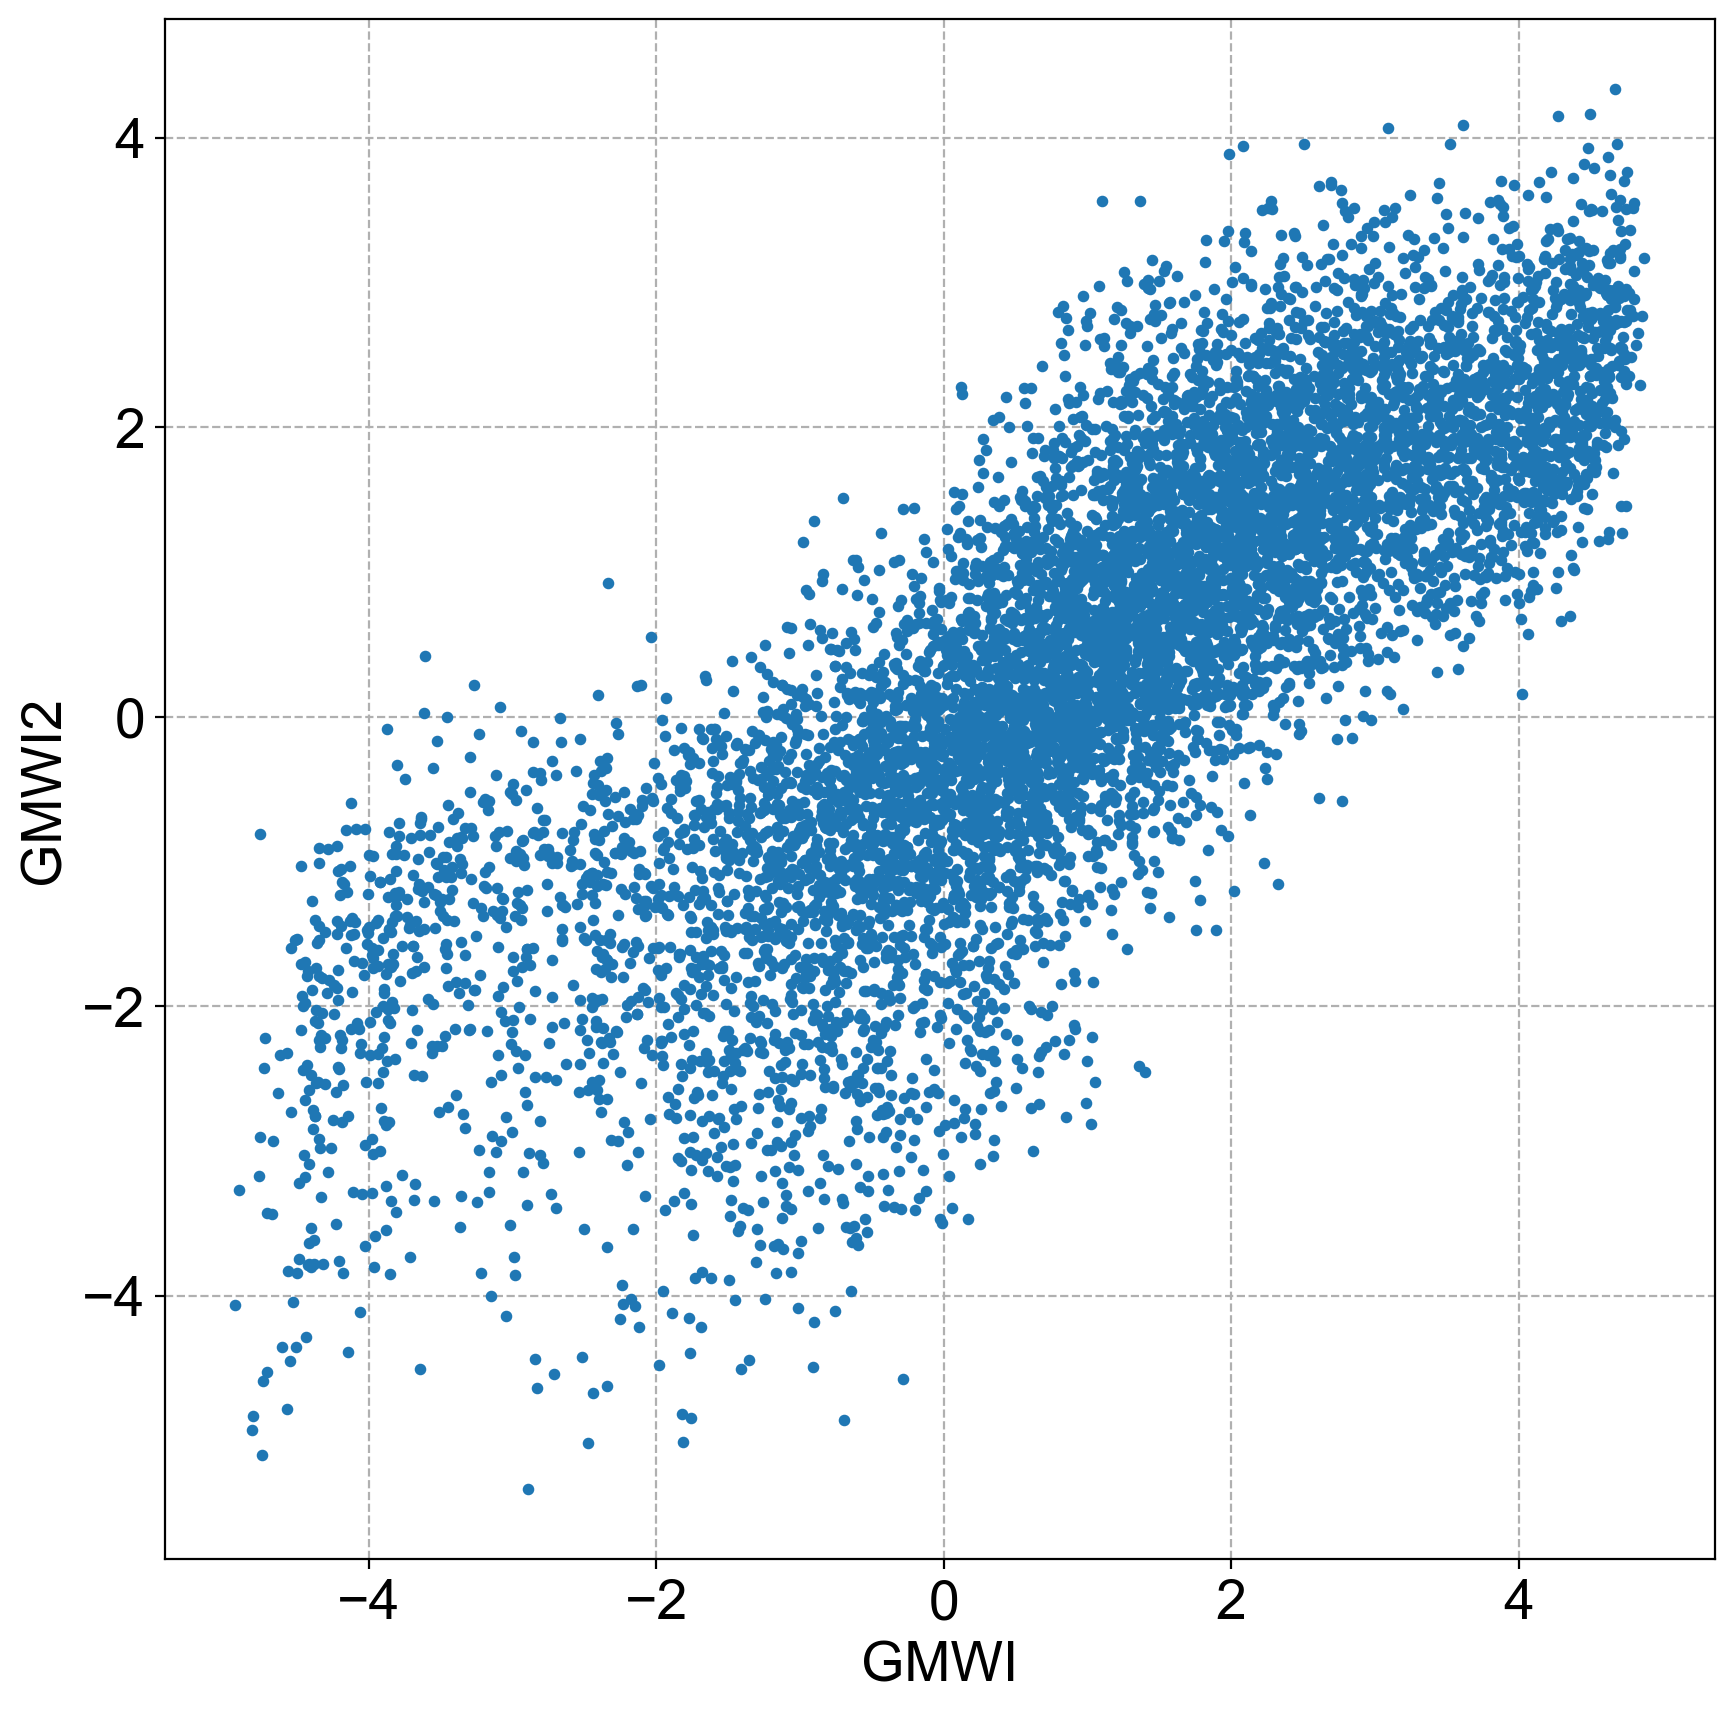

In [313]:
plt.figure(figsize=(10, 10), dpi=200)
plt.grid(True, linestyle='--')

plt.scatter(GMWI_scores, GMWI2_scores, s=10)
plt.xlabel("GMWI", fontsize=20)
plt.ylabel("GMWI2", fontsize=20)
print(pearsonr(GMWI_scores.values.flatten(), GMWI2_scores.values.flatten(), method=MonteCarloMethod()))

tickfont = 20
plt.xticks(fontsize=tickfont)
plt.yticks(fontsize=tickfont)

ax = plt.gca()

ax.set_axisbelow(True)

# GMWI2 model coefficients (Fig. 1c)

In [270]:
coefficients = pd.DataFrame(gmwi2.coef_.flatten(), index=gmwi2.feature_names_in_, columns=["Coefficient"])
sorted_coefficients = coefficients.sort_values("Coefficient", ascending=False)

In [272]:
num_pos = (sorted_coefficients > 0).sum().sum()
num_neg = (sorted_coefficients < 0).sum().sum()
num_zero = (sorted_coefficients == 0).sum().sum()
num_coef = sorted_coefficients.shape[0]
buffer = 5
print(f"We have {num_pos} positive coefficients, {num_neg} negative coefficients, and {num_zero} zero coefficients")
print(f"{num_coef} coefficients in total")

We have 49 positive coefficients, 46 negative coefficients, and 3105 zero coefficients
3200 coefficients in total


In [278]:
healthy_color = "steelblue"
zero_color = "darkviolet"
nonhealthy_color = 'orange'

colors = [healthy_color if x > 0 else nonhealthy_color if x < 0 else zero_color
    for x in sorted_coefficients.values.flatten()]

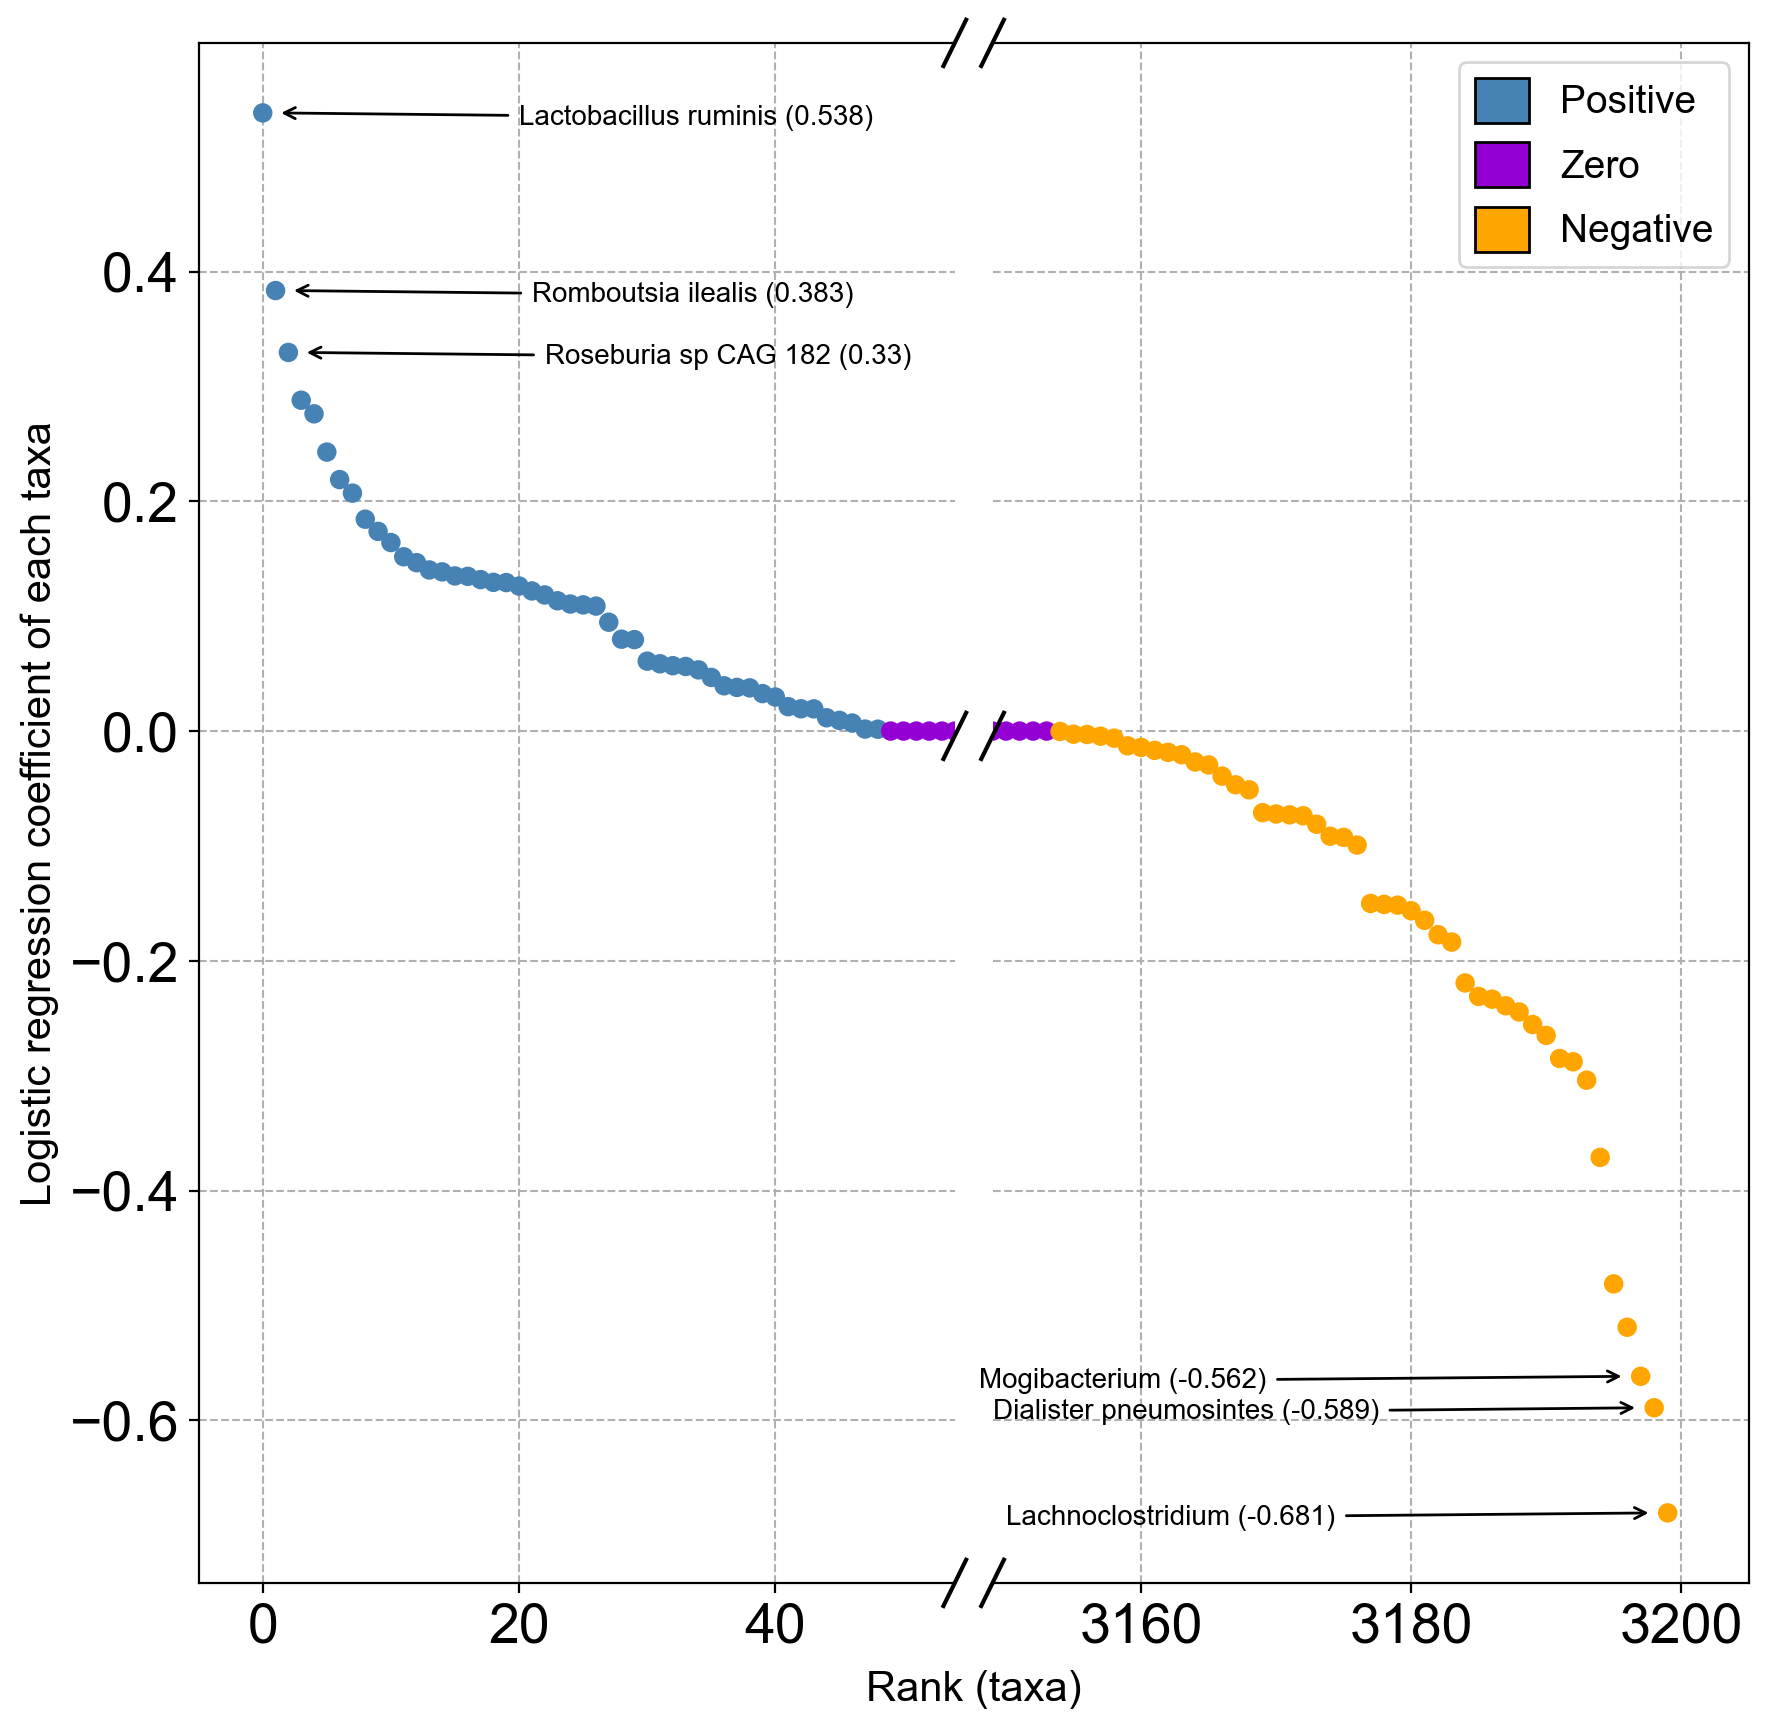

In [287]:
# Create two plots side by side with a shared y
fig, (ax, ax2) = plt.subplots(1,2, sharey=True, facecolor='w', figsize=(10, 10), dpi=200)

# plot the same data on each plot
axes = [ax, ax2]
for i, a in enumerate(axes):
    # give us a nice grid
    a.set_axisbelow(True)
    a.grid(linestyle = '--', linewidth = 0.75)
    
    # set the y label for the left plot
    if i == 0:
        a.set_ylabel("Logistic regression coefficient of each taxa", fontsize=15)
        
    # Big ticks
    a.tick_params(axis="both", labelsize=20)
    
    # plot the coefficients
    a.scatter(np.arange(sorted_coefficients.shape[0]), sorted_coefficients, c=colors)
    
# Broken axis effect
ax.set_xlim(-5, num_pos + buffer)
ax2.set_xlim(num_coef - num_neg - buffer, num_coef + 5)
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)


# Make the broken axis diagonal lines
d = .015

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)

middle_diag = 0.55
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # bottom-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (middle_diag - d, middle_diag + d), **kwargs)  # middle-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (-d, +d), **kwargs)        # bottom-right diagonal
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # top-right diagonal
ax2.plot((-d, +d), (middle_diag - d, middle_diag + d), **kwargs)  # middle-right diagonal

fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Rank (taxa)", fontsize=15, labelpad=15)

fig.subplots_adjust(wspace=0.05)

# annotate high magnitude coeffcients (pos and neg)
for i in range(3):
    x, y = i, float(sorted_coefficients.iloc[i])
    taxa = sorted_coefficients.index[i].split("__")[-1].replace("_", " ")
    ax.annotate(r"" + taxa + '' + f" ({round(y, 3)})", xy=(x + 1, y), xytext=(x + 20, y - 0.01),
                arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
                fontsize=10
    )
    
for i in range(3):
    idx = -(1 + i)
    x, y = i, float(sorted_coefficients.iloc[idx])
    x = num_coef - x
    taxa = sorted_coefficients.index[idx].split("__")[-1].replace("_", " ")
    ax2.annotate(r"" + taxa + '' + f" ({round(y, 3)})", xy=(x - 2, y), xytext=(x - 50, y - 0.01),
                arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
                fontsize=10
    )
    
# Add legend
handles = [
    Patch(facecolor=healthy_color, edgecolor="k", label="Positive", alpha=1),
    Patch(facecolor=zero_color, edgecolor="k", label="Zero", alpha=1),
    Patch(facecolor=nonhealthy_color, edgecolor="k", label="Negative", alpha=1),
]

plt.legend(handles=handles, prop={'size': 14}, loc=1, handlelength=1.4, handleheight=1.4)
    

# Compute indices on the pooled dataset (Fig. 1c)

In [290]:
# compute alpha diversity
X_species = X[list(filter(lambda x : "s__" in x, X.columns))]
richness = pd.DataFrame((X_species > PRESENCE_CUTOFF).sum(axis=1), columns=["Species Richness"])
shannon = pd.DataFrame(np.sum((-X_species * np.log(X_species)).fillna(0), axis=1), columns=["Shannon Diversity"])
simpson = pd.DataFrame(1 - np.sum(X_species ** 2, axis=1), columns=["Simpson Diversity"])

In [292]:
y = training_set[["is_healthy"]]

num_healthy = y.values.sum()
num_nonhealthy = y.shape[0] - y.values.sum()
num_healthy, num_nonhealthy

(5547, 2522)

In [293]:
healthy_nonhealthy = y.copy()
healthy_nonhealthy.columns = ["Health status"]
healthy_text = f"Healthy\n ({num_healthy})"
nonhealthy_text = f"Nonhealthy\n ({num_nonhealthy})"
healthy_nonhealthy[y.values] = healthy_text
healthy_nonhealthy[~y.values] = nonhealthy_text

data = pd.concat([GMWI2_scores, GMWI_scores, healthy_nonhealthy, richness, shannon, simpson], axis=1)
data

GMWI2      GMWI     Health status  \
Study_ID            Sample Accession                                         
Obregon-Tito (2015) SAMN03283239      1.835237  3.832094  Healthy\n (5547)   
                    SAMN03283266      0.103722  1.758548  Healthy\n (5547)   
                    SAMN03283281      1.116329  3.341858  Healthy\n (5547)   
                    SAMN03283294      1.758818  1.429055  Healthy\n (5547)   
                    SAMN03283288      1.675791  1.064592  Healthy\n (5547)   
...                                        ...       ...               ...   
Yang (2020)         SRR6456373       -1.029233 -4.472053  Healthy\n (5547)   
                    SRR6456374       -0.941967 -2.158801  Healthy\n (5547)   
                    SRR6456375       -0.030621  0.280615  Healthy\n (5547)   
                    SRR6456376        0.973798  1.132266  Healthy\n (5547)   
                    SRR6456377       -0.066339 -0.305132  Healthy\n (5547)   

                                      Species Richness  Shannon Diversity  \
Study_ID            Sample Accession                                        
Obregon-Tito (2015) SAMN03283239                    51           2.429760   
                    SAMN03283266                    76           2.711069   
                    SAMN03283281                    74           2.885216   
                    SAMN03283294                    94           2.533818   
                    SAMN03283288                   113           3.133189   
...                                                ...                ...   
Yang (2020)         SRR6456373                      73           2.393276   
                    SRR6456374                      80           2.682308   
                    SRR6456375                      90           2.734653   
                    SRR6456376                      89           2.763858   
                    SRR6456377                      77           1.725367   

                                      Simpson Diversity  
Study_ID            Sample Accession                     
Obregon-Tito (2015) SAMN03283239               0.803097  
                    SAMN03283266               0.880476  
                    SAMN03283281               0.903475  
                    SAMN03283294               0.841909  
                    SAMN03283288               0.901469  
...                                                 ...  
Yang (2020)         SRR6456373                 0.829690  
                    SRR6456374                 0.906057  
                    SRR6456375                 0.933497  
                    SRR6456376                 0.934235  
                    SRR6456377                 0.606075  

[8069 rows x 6 columns]

In [294]:
def observeDifference(a, b):
    u, man_whitney_u_p_val = mannwhitneyu(a, b)
    cliffs_delta = (2 * u) / (a.shape[0] * b.shape[0]) - 1
    return cliffs_delta, man_whitney_u_p_val

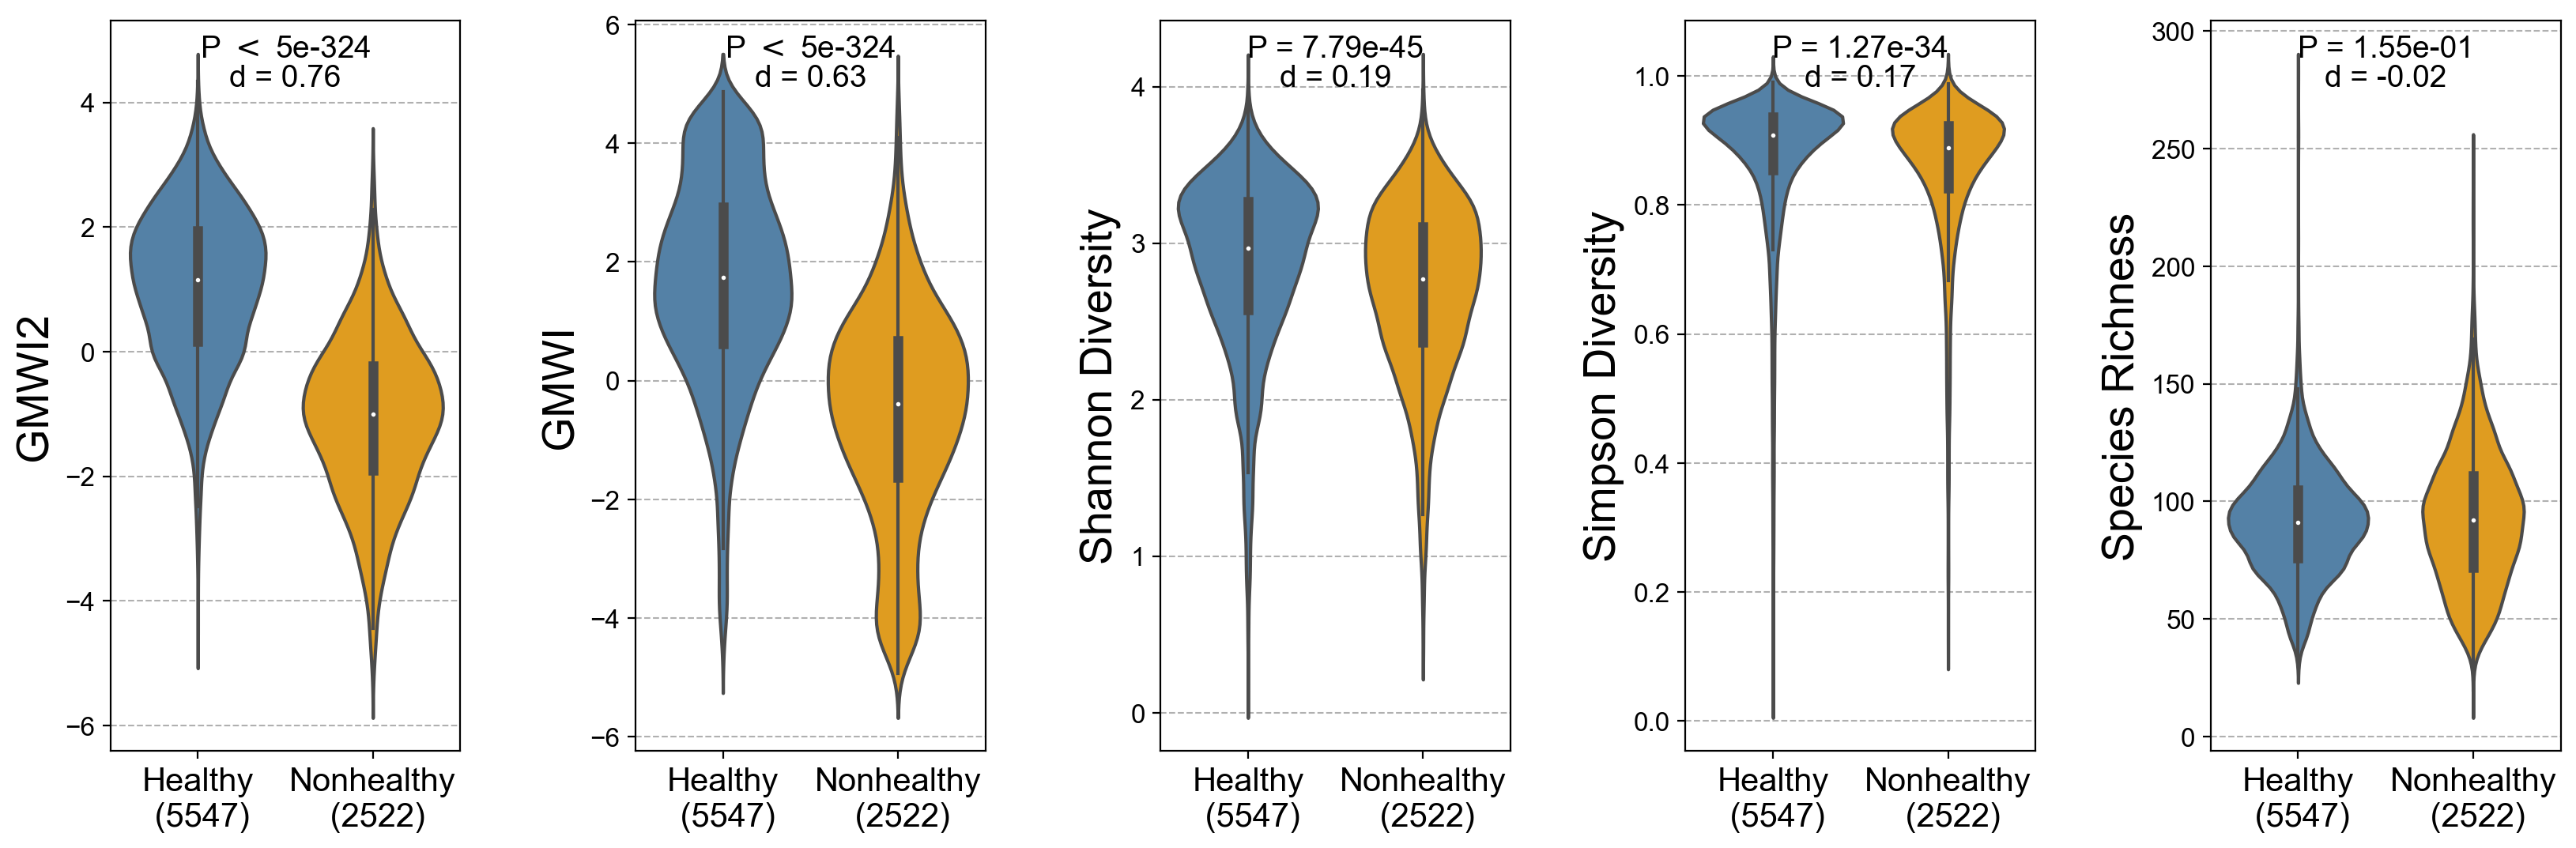

In [304]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 6), dpi=200)
indices = ["GMWI2", "GMWI", "Shannon Diversity", "Simpson Diversity", "Species Richness"]
for ind, ax in zip(indices, axs):
    v = sns.violinplot(x="Health status", y=ind, data=data, ax=ax, 
                   palette={healthy_text : healthy_color, nonhealthy_text : nonhealthy_color})
    cliffs_delta, man_whitney_u_p_val = observeDifference(data[ind].iloc[y.values], data[ind].iloc[~y.values])
    
    p_text = (r"P $<$ " + str(np.nextafter(0, 1))) if man_whitney_u_p_val == 0 else (
        r"P = " + str(np.format_float_scientific(man_whitney_u_p_val, precision=2))
    )
    
    ax.text(0.5, 0.95, p_text, fontsize=14,
        horizontalalignment='center', transform=ax.transAxes
    )
    ax.text(0.5, 0.91, f"d = {'%.2f' % cliffs_delta}", fontsize=14,
        horizontalalignment='center', transform=ax.transAxes
    )
    
    v.tick_params(axis="y", labelsize=12)
    v.tick_params(axis="x", labelsize=15)
    ax.yaxis.label.set_size(20)
    ax.set_axisbelow(True)
    ax.grid(linestyle = '--', axis="y", linewidth = 0.75)
    ax.set_xlabel("")
fig.subplots_adjust(wspace=0.5)

# GMWI2 scores for different phenotypes (Fig. 1e)

In [305]:
phenotypes = np.unique(phenotype.values)
phenotypes

array(['Ankylosing spondylitis', 'Atherosclerotic cardiovascular disease',
       'Colorectal cancer', "Crohn's Disease", 'Graves’ disease',
       'Healthy', 'Liver Cirrhosis', 'MS', 'NAFLD',
       'Rheumatoid arthritis', 'Type 2 diabetes', 'Ulcerative colitis'],
      dtype=object)

In [306]:
scores = {p : GMWI2_scores[phenotype.iloc[:, 0] == p].values.flatten() for p in phenotypes}

In [307]:
means = {p : scores[p].mean() for p in scores}

In [308]:
sorted_phenotypes = sorted(list(phenotypes), key=lambda x : means[x], reverse=True)
sorted_phenotypes

['Healthy',
 'MS',
 'Ankylosing spondylitis',
 'Ulcerative colitis',
 'Rheumatoid arthritis',
 'NAFLD',
 'Type 2 diabetes',
 "Crohn's Disease",
 'Graves’ disease',
 'Colorectal cancer',
 'Liver Cirrhosis',
 'Atherosclerotic cardiovascular disease']

In [309]:
phenotype_to_label = {
    "Healthy" : "Healthy",
    'MS' : "MS",
    'Ankylosing spondylitis' : "AS",
    'Ulcerative colitis' : "UC",
    'Rheumatoid arthritis' : "RA",
    'NAFLD' : "NAFLD",
    'Type 2 diabetes' : "T2D",
    "Crohn's Disease" : "CD",
    'Graves’ disease' : "GD",
    'Colorectal cancer' : "CC",
    'Liver Cirrhosis' : "LC",
    'Atherosclerotic cardiovascular disease' : "ACVD"
}

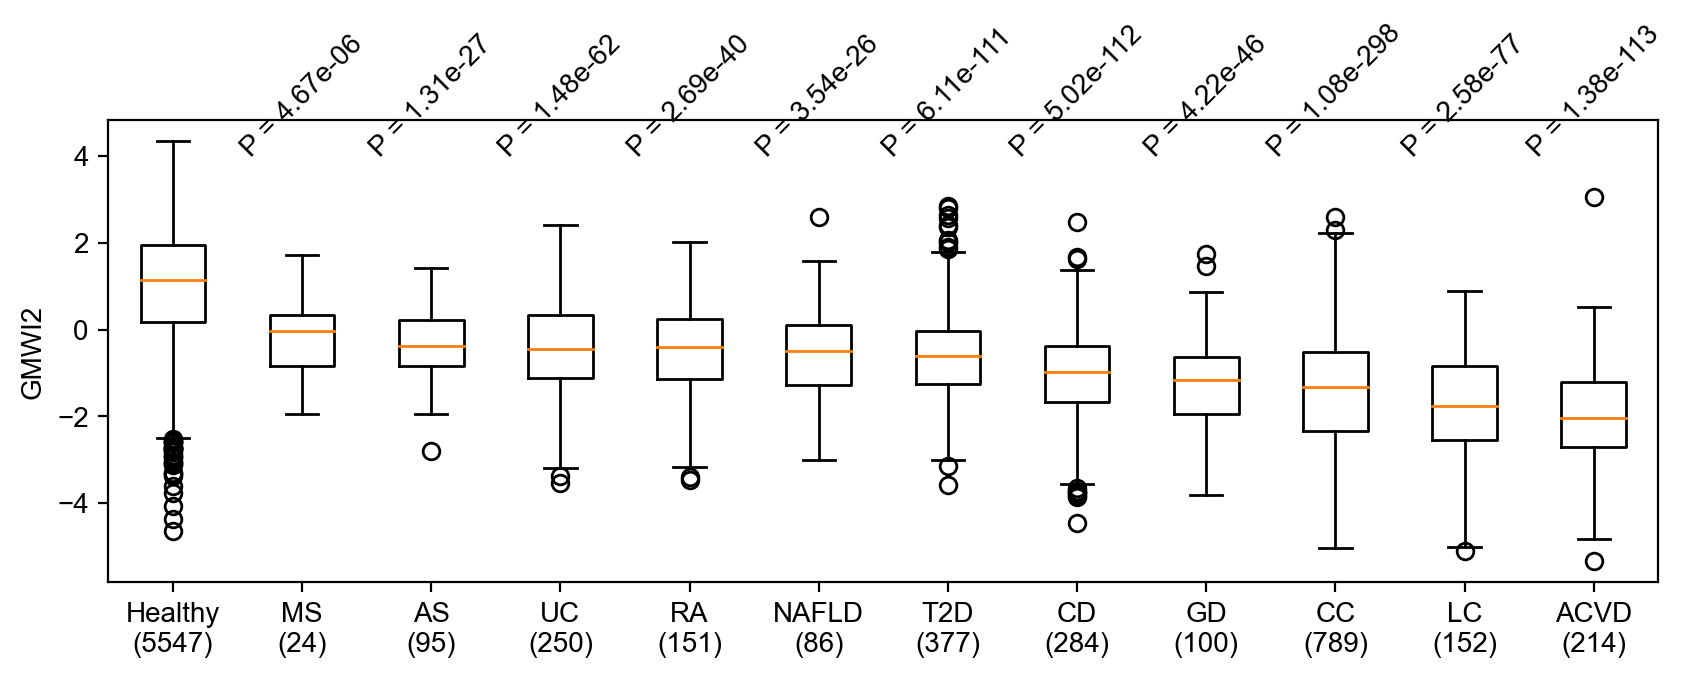

In [332]:
plt.figure(figsize =(10, 3), dpi=200)

labels = [phenotype_to_label[p] + f"\n({phenotype.iloc[phenotype.values == p].shape[0]})" for p in sorted_phenotypes]

plt.boxplot([scores[p] for p in sorted_phenotypes], labels=labels, showfliers=True)

for i, p in enumerate(sorted_phenotypes):
    if p == "Healthy" : continue
    pval = mannwhitneyu(scores["Healthy"], scores[p]).pvalue
    plt.text(i + 1, 4, "P = {0:.3g}".format(pval), horizontalalignment="center", rotation=45)

plt.ylabel("GMWI2")

plt.show()

# GMWI2 and GMWI healthy vs nonhealthy stratification (Fig. 1f and Supplementary table 1)

In [352]:
bins = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
healthy_prop = []
nonhealthy_prop = []
healthy_count = []
nonhealthy_count = []

for left, right in zip(bins, bins[1:]):
    bin_ = y.iloc[(GMWI2_scores.values.flatten() > left) & (GMWI2_scores.values.flatten() <= right)]
    healthy_prop.append(bin_.mean())
    nonhealthy_prop.append(1 - bin_.mean())
    
    healthy_count.append(bin_.sum())
    nonhealthy_count.append(bin_.shape[0] - bin_.sum())

In [353]:
def get_props(index_values):
    bins = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    healthy_prop = []
    nonhealthy_prop = []
    healthy_count = []
    nonhealthy_count = []

    for left, right in zip(bins, bins[1:]):
        bin_ = y.iloc[(index_values.values.flatten() > left) & (index_values.values.flatten() <= right)]
        healthy_prop.append(bin_.mean())
        nonhealthy_prop.append(1 - bin_.mean())

        healthy_count.append(bin_.sum())
        nonhealthy_count.append(bin_.shape[0] - bin_.sum())
    return healthy_prop, nonhealthy_prop, healthy_count, nonhealthy_count

In [355]:
gmwi2_healthy_prop, gmwi2_nonhealthy_prop, gmwi2_healthy_count, gmwi2_nonhealthy_count = get_props(GMWI2_scores)
gmwi_healthy_prop, gmwi_nonhealthy_prop, gmwi_healthy_count, gmwi_nonhealthy_count = get_props(GMWI_scores)

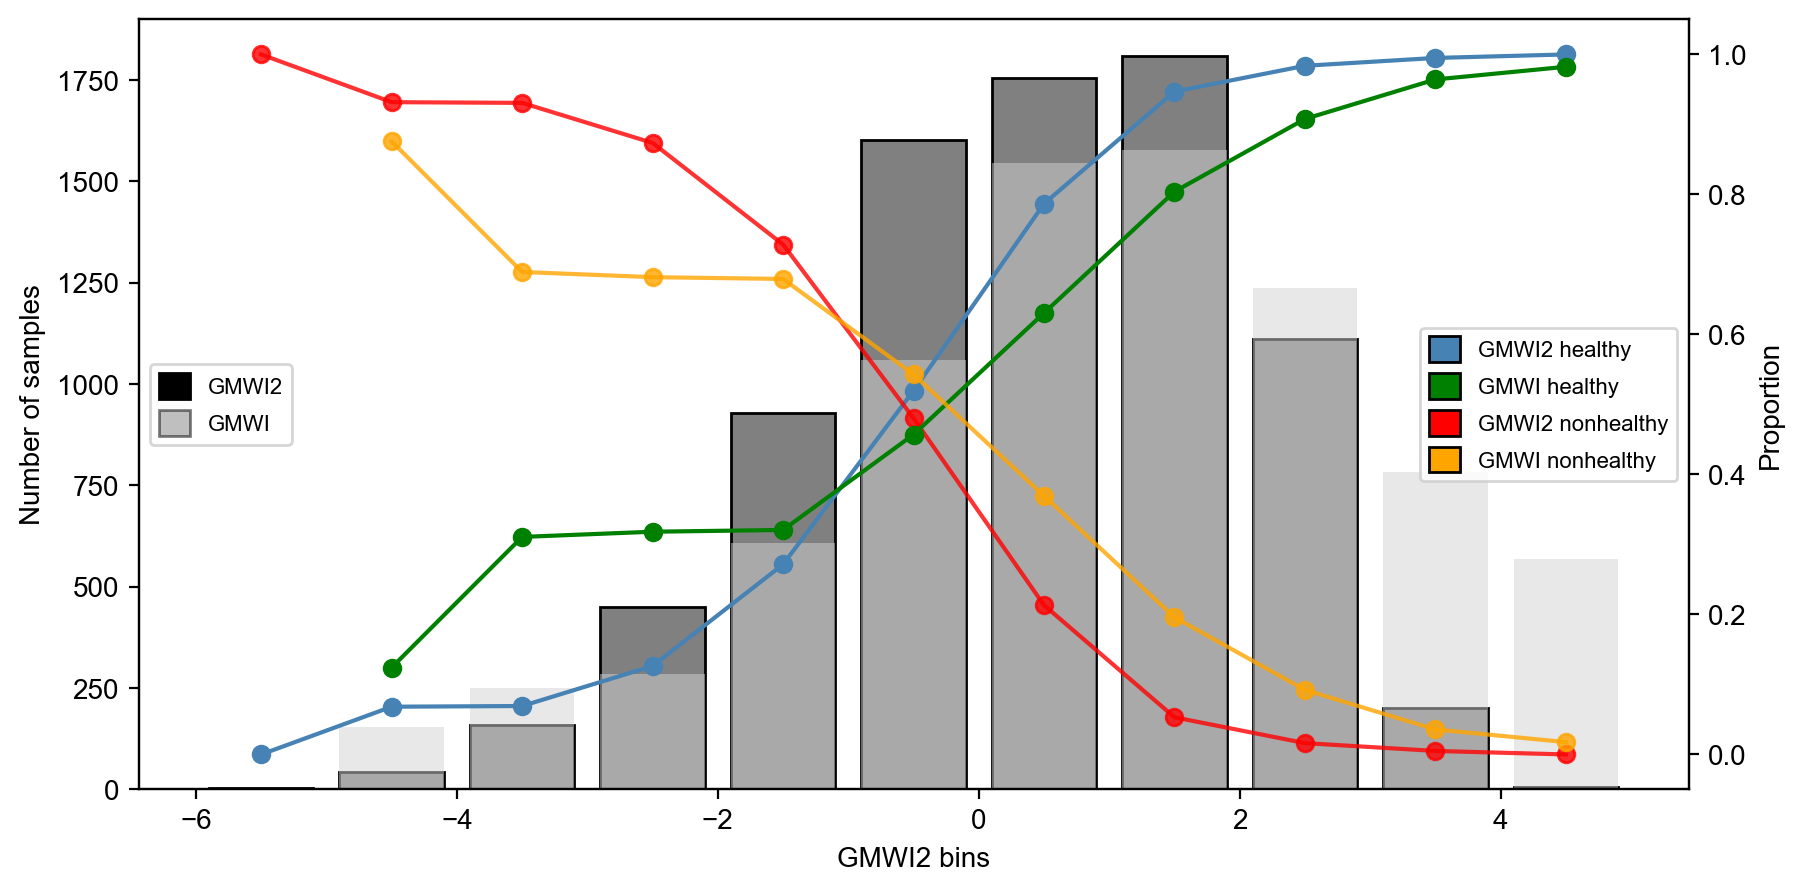

In [365]:
plt.figure(figsize=(10, 5), dpi=200)
ax = plt.gca()

rwidth = 0.8
ax.hist(GMWI2_scores, bins=bins, edgecolor = "black", color="gray", label="GMWI2", rwidth=rwidth)
ax.hist(GMWI_scores, bins=bins, color="lightgray", label="GMWI", alpha=0.5, rwidth=rwidth)

ax.set_ylabel("Number of samples")
ax.set_xlabel("GMWI2 bins")

ax_new = ax.twinx()

plot_locations = np.array(bins[:-1]) + 0.5

#gmwi2
ax_new.plot(plot_locations, gmwi2_healthy_prop, "o-", color="steelblue")
ax_new.plot(plot_locations, gmwi2_nonhealthy_prop, "o-", color="red", alpha=0.8)

#gmwi
ax_new.plot(plot_locations, gmwi_healthy_prop, "o-", color="green")
ax_new.plot(plot_locations, gmwi_nonhealthy_prop, "o-", color="orange", alpha=0.8)

ax_new.set_ylabel("Proportion")

handles = [
    Patch(facecolor="black", edgecolor="k", label="GMWI2"),
    Patch(facecolor="gray", edgecolor="k", label="GMWI", alpha=0.5),
]

ax.legend(handles=handles, prop={'size': 8}, loc=6, handlelength=1.4, handleheight=1.4)

handles = [
    Patch(facecolor="steelblue", edgecolor="k", label="GMWI2 healthy"),
    Patch(facecolor="green", edgecolor="k", label="GMWI healthy"),
    Patch(facecolor="red", edgecolor="k", label="GMWI2 nonhealthy"),
    Patch(facecolor="orange", edgecolor="k", label="GMWI nonhealthy"),
]

ax_new.legend(handles=handles, prop={'size': 8}, loc=0, handlelength=1.4, handleheight=1.4)

plt.show()

In [366]:
sample_info = pd.DataFrame()
sample_info["Bin range"] = [f"({l}, {r}]" for l, r in zip(bins, bins[1:])]
sample_info["GMWI2: Number of healthy samples in bin (proportion of total in bin)"] = [f"{int(count)}" + f" ({float(prop):.1%})" for count, prop in zip(gmwi2_healthy_count, gmwi2_healthy_prop)]
sample_info["GMWI2: Number of non-healthy samples in bin (proportion of total in bin)"] = [f"{int(count)}" + f" ({float(prop):.1%})" for count, prop in zip(gmwi2_nonhealthy_count, gmwi2_nonhealthy_prop)]
sample_info["GMWI: Number of healthy samples in bin (proportion of total in bin)"] = [f"{int(count)}" + f" ({float(prop):.1%})" for count, prop in zip(gmwi_healthy_count, gmwi_healthy_prop)]
sample_info["GMWI: Number of non-healthy samples in bin (proportion of total in bin)"] = [f"{int(count)}" + f" ({float(prop):.1%})" for count, prop in zip(gmwi_nonhealthy_count, gmwi_nonhealthy_prop)]
sample_info

,Bin range,GMWI2: Number of healthy samples in bin (proportion of total in bin),GMWI2: Number of non-healthy samples in bin (proportion of total in bin),GMWI: Number of healthy samples in bin (proportion of total in bin),GMWI: Number of non-healthy samples in bin (proportion of total in bin)
0,"(-6, -5]",0 (0.0%),4 (100.0%),0 (nan%),0 (nan%)
1,"(-5, -4]",3 (6.8%),41 (93.2%),19 (12.4%),134 (87.6%)
2,"(-4, -3]",11 (6.9%),148 (93.1%),78 (31.1%),173 (68.9%)
3,"(-3, -2]",57 (12.6%),394 (87.4%),91 (31.8%),195 (68.2%)
4,"(-2, -1]",252 (27.2%),676 (72.8%),195 (32.1%),413 (67.9%)
5,"(-1, 0]",833 (52.0%),770 (48.0%),484 (45.7%),575 (54.3%)
6,"(0, 1]",1380 (78.7%),374 (21.3%),975 (63.1%),571 (36.9%)
7,"(1, 2]",1713 (94.7%),96 (5.3%),1268 (80.4%),309 (19.6%)
8,"(2, 3]",1094 (98.4%),18 (1.6%),1123 (90.8%),114 (9.2%)
9,"(3, 4]",199 (99.5%),1 (0.5%),756 (96.4%),28 (3.6%)


# Performance vs cutoff (Fig. 1g and Supplementary table 2)

In [377]:
def get_cutoff_performance_df(scores, max_cutoff, interval=0.1):
    dict_list = []
    for cutoff in np.arange(0, max_cutoff + interval, interval):
        idx = (abs(scores) >= cutoff).values
        samples_retained = float(idx.sum())
        bal_acc = balanced_accuracy_score(y[idx], scores[idx] > 0)
        dict_list.append({
            "cutoff" : cutoff,
            "samples retained" : samples_retained,
            "bal_acc" : bal_acc
        })
    df = pd.DataFrame(dict_list)
    return df

def plot_performance_vs_cutoff(scores, max_cutoff, left_y_label):
    df = get_cutoff_performance_df(scores, max_cutoff)
    display(df)
    fig, ax1 = plt.subplots(figsize=(10, 5), dpi=200)

    ax2 = ax1.twinx()
    ax1.plot(df["cutoff"], df["bal_acc"], c="steelblue")
    ax2.plot(df["cutoff"], df["samples retained"], c="orange")

    ax1.set_axisbelow(True)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax1.grid(linestyle = '--', linewidth = 0.75)

    ax1.tick_params(axis="both", labelsize=15)
    ax2.tick_params(axis="both", labelsize=15)

    samples_range = df["samples retained"].max() - df["samples retained"].min()
    acc_range = df["bal_acc"].max() - df["bal_acc"].min()
    
    yticks = [df["samples retained"].min() + (t - df["bal_acc"].min()) * samples_range / acc_range for t in ax1.get_yticks()[1:-1]]
    
    ax2.set_yticks(yticks)

    ax1.set_ylabel(left_y_label, fontsize=15)
    ax2.set_ylabel("Samples retained", fontsize=15)
    ax1.set_xlabel("GMWI2 Magnitude Cutoff", fontsize=15)
    plt.show()

,cutoff,samples retained,bal_acc
0,0.0,8069.0,0.798853
1,0.1,7719.0,0.811917
2,0.2,7333.0,0.824876
3,0.3,7004.0,0.835330
4,0.4,6691.0,0.846499
5,0.5,6364.0,0.857515
6,0.6,6029.0,0.870530
7,0.7,5664.0,0.882040
8,0.8,5365.0,0.891837
9,0.9,5049.0,0.901703


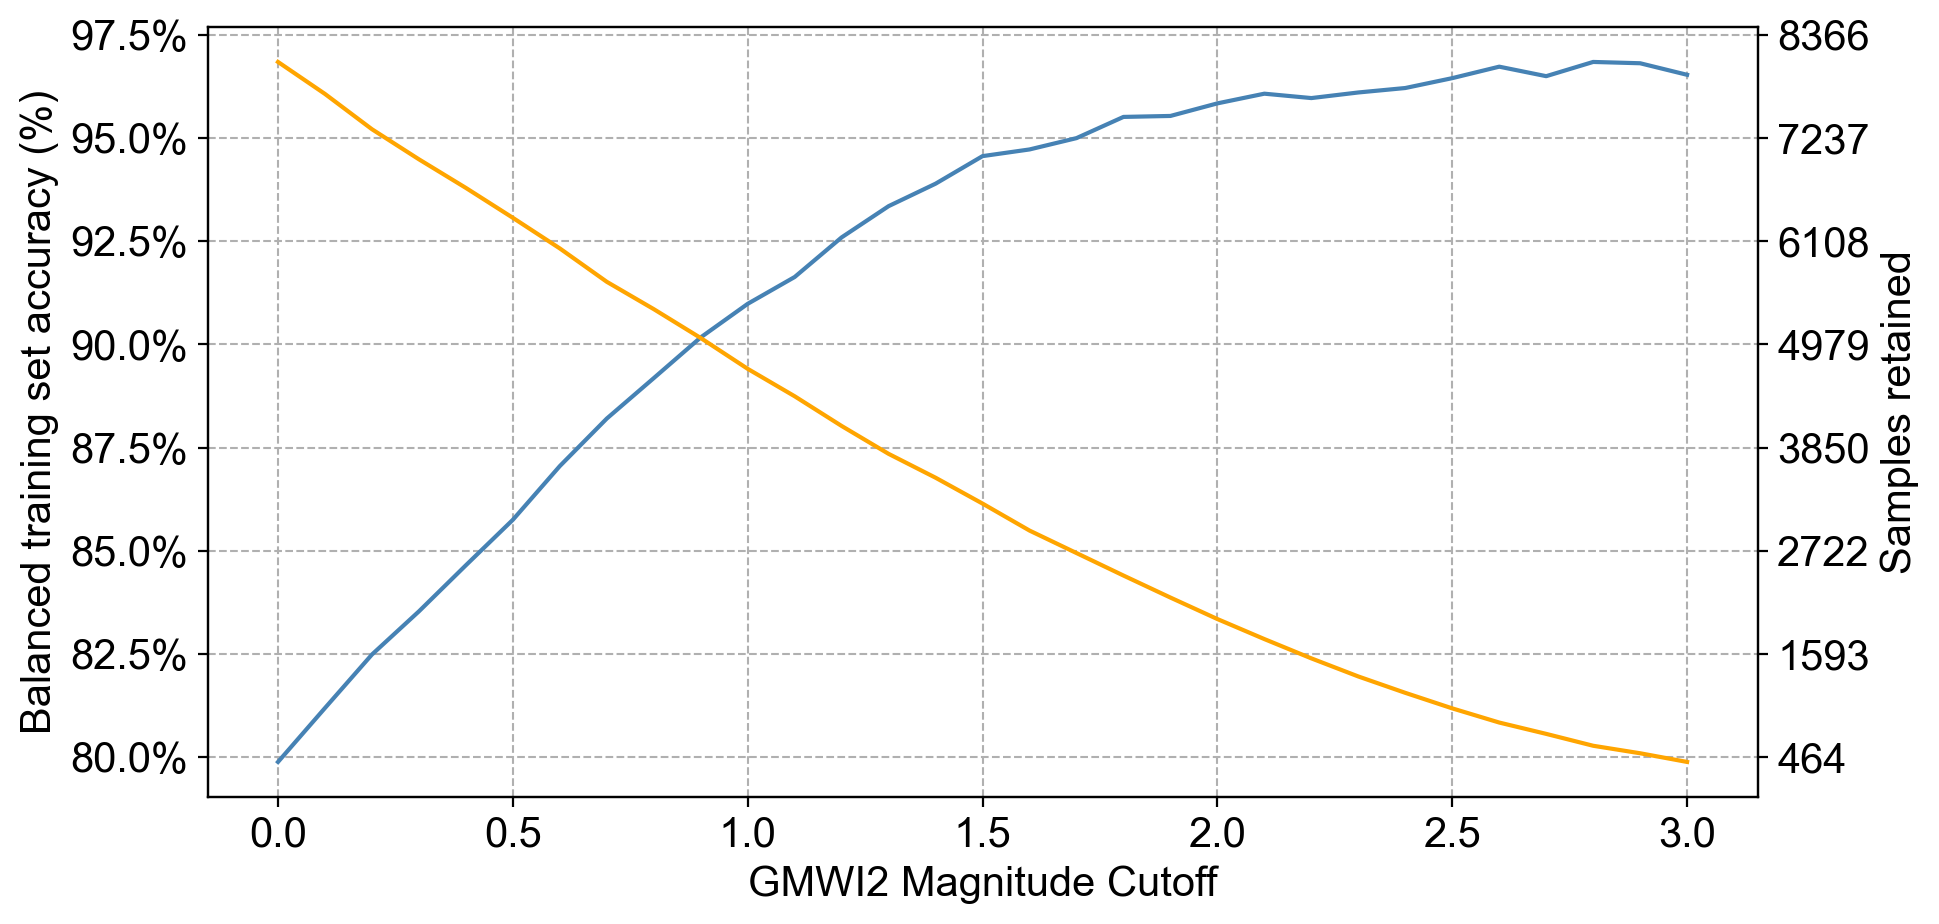

In [378]:
plot_performance_vs_cutoff(GMWI2_scores, 3, "Balanced training set accuracy (%)")

# Compute 10-fold and LOOCV logit predictions

In [415]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=np.random.randint(0, high=1000000))

# instantiate the logistic regression classifier (gmhi2)
gmwi2_kfold = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=REGULARIZATION, class_weight="balanced")

# generate logit predictions in 10 fold cross validation
GMWI2_scores_kfold = cross_val_predict(gmwi2_kfold, X > PRESENCE_CUTOFF, y.values.flatten(), method="decision_function",
    cv=kfold, verbose=2, n_jobs=-1
)

GMWI2_scores_kfold = pd.DataFrame(GMWI2_scores_kfold, index=y.index, columns=["GMHI2_kfold"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.2s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.0s finished


In [419]:
leave = LeaveOneOut()
    
# instantiate the logistic regression classifier (gmhi2)
gmwi2_loo = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=REGULARIZATION, class_weight="balanced")

# generate logit predictions in LOOCV
GMWI2_scores_loo = cross_val_predict(gmwi2_loo, X > PRESENCE_CUTOFF, y.values.flatten(), method="decision_function",
    cv=leave, verbose=2, n_jobs=-1
)

GMWI2_scores_loo = pd.DataFrame(GMWI2_scores_loo, index=y.index, columns=["GMWI2_loo"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 3249 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 4869 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 6813 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 7906 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 8069 out of 8069 |

In [421]:
GMWI2_scores_loo.to_csv("GMWI2_scores_loo")

# Performance vs cutoff for all cv methods (Fig. 1h)

In [441]:
perf_cutoff_all = []

for cutoff in [0, 0.5, 1]:
    for index, score in [
        ("GMWI training", GMWI_scores), 
        ("GMWI2 training", GMWI2_scores),
        ("GMWI2 LOOCV", GMWI2_scores_loo),
        ("GMWI2 10-fold", GMWI2_scores_kfold),
    ]:
        keep = score.iloc[:, 0].abs() > cutoff
        curr_y = y[keep].iloc[:, 0]
        score = score[keep].iloc[:, 0]
        pred = score > 0
        balanced = balanced_accuracy_score(curr_y, pred)
        healthy = float((pred & curr_y).sum() / curr_y.sum())
        nonhealthy = float((~pred & ~curr_y).sum() / (~curr_y).sum())
        
        perf_cutoff_all.append({
            "cutoff" : cutoff,
            "index" : index,
            "healthy" : healthy,
            "non-healthy" : nonhealthy,
            "balanced accuracy" : balanced,
        })
        
perf_df = pd.DataFrame(perf_cutoff_all)
perf_df

,cutoff,index,healthy,non-healthy,balanced accuracy
0,0.0,GMWI training,0.843699,0.590801,0.717250
1,0.0,GMWI2 training,0.791599,0.806106,0.798853
2,0.0,GMWI2 LOOCV,0.786371,0.795004,0.790687
3,0.0,GMWI2 10-fold,0.787092,0.789849,0.788471
4,0.5,GMWI training,0.880419,0.618277,0.749348
5,0.5,GMWI2 training,0.850972,0.864058,0.857515
6,0.5,GMWI2 LOOCV,0.846955,0.852062,0.849508
7,0.5,GMWI2 10-fold,0.846171,0.848154,0.847163
8,1.0,GMWI training,0.906311,0.664971,0.785641
9,1.0,GMWI2 training,0.903119,0.916546,0.909833


# Apply GMWI2 to longitudinal case studies

### Tanes *et al.* 2021 (dietary fiber)

In [14]:
tanes = longitudinal_cases.loc["Tanes (2021)"]
tanes

,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae,k__Archaea|p__Euryarchaeota|c__Thermoplasmata,...,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cucumber_green_mottle_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Paprika_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Pepper_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Tobacco_mild_green_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Deep_sea_thermophilic_phage_D6E,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Loktanella_phage_pCB2051_A,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Tetraselmis_viridis_virus_S1,Subject_ID,health_status/host_diet,timepoint
Sample Accession,,,,,,,,,,,,,,,,,,,,,
SAMEA7082340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,11,Irritable bowel syndrome (IBS),0
SAMEA7082341,0.018776,0.018776,0.018776,0.018776,0.018776,0.018776,0.018776,0.0,0.0,0.0,...,0,0,0,0,0,0,0,11,Irritable bowel syndrome (IBS),12
SAMEA7082342,0.013714,0.013714,0.013714,0.013714,0.013714,0.013714,0.013714,0.0,0.0,0.0,...,0,0,0,0,0,0,0,11,Irritable bowel syndrome (IBS),6
SAMEA7082343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,Irritable bowel syndrome (IBS),0
SAMEA7082344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,12,Irritable bowel syndrome (IBS),12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7082429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,D-6Fresk_S5,Healthy,NaN
SAMEA7082430,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,D-6Fryst_S4,Healthy,NaN
SAMEA7082431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,D-7Fryst_S7,Healthy,NaN
